-----------------------------
# Rafi Fadhlillah
# 121450143
# Deep Learning RC
-----------------------------

# Buat model Seq2Seq. Terjemahkan:
- Bahasa inggris : how are you?
- Bahasa Prancis: comment vas-tu?

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 2.5431
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 2.5073
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 2.4770
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 2.4456
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.4083
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 2.3575
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 2.2765
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 2.1240
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 1.8728
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.6632
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 1.5315
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 2.0567
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 1.8240
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 1.4697
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.3755
Epoch 16

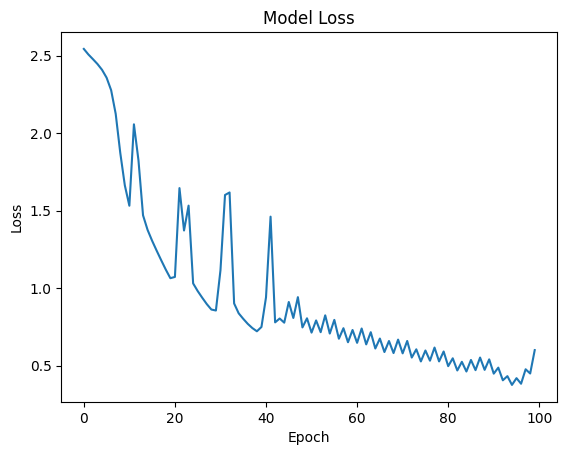

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# Preprocessing data
input_texts = ["how are you?"]
target_texts = ["\tcomment vas-tu?\n"]
input_characters = sorted(list(set("".join(input_texts))))
target_characters = sorted(list(set("".join(target_texts))))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Build model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile and train the model
history = model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=100,
)

# Inference model for translation
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Translation function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = {i: char for char, i in target_token_index.items()}[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# Test translation
input_seq = encoder_input_data[0:1]
decoded_sentence = decode_sequence(input_seq)
input_text = "".join([input_characters[np.argmax(i)] for i in encoder_input_data[0]])

print("Input text:", input_text)  # Menampilkan teks input sebelum diterjemahkan
print("Decoded sentence:", decoded_sentence)  # Menampilkan hasil terjemahan

# Plot Training Loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Terjadi perbedaan dalam hasil terjemahan karena model mungkin belum sepenuhnya terlatih dengan data yang sangat terbatas. Model LSTM ini bekerja dengan mempelajari pola dalam data, dan dengan hanya satu contoh pelatihan ("how are you?" → "\tcomment vas-tu?\n"), model mungkin belum mampu menghasilkan terjemahan yang akurat.

## 1. Bagaimana cara memodifikasi laju pembelajaran (learning rate) dan ukuran batch untuk meningkatkan kinerja model sequence-to-sequence?

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.3266
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.3114
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.2954
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 2.2773
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 2.2549
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 2.2239
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.1749
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 2.0907
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.9802
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.9316
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.8640
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 1.7996
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.7529
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.7118
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.6726
Epoch 16/1

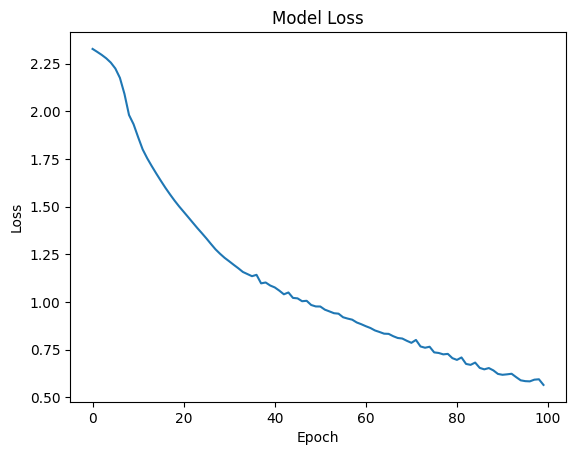

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# Preprocessing data
input_texts = ["how are you?", "what is your name?", "how old are you?"]
target_texts = ["\tcomment vas-tu?\n", "\tcomment tu t'appelles?\n", "\tquel âge as-tu?\n"]

input_characters = sorted(list(set("".join(input_texts))))
target_characters = sorted(list(set("".join(target_texts))))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Build model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Define learning rate and batch size
learning_rate = 0.001  # Learning rate
batch_size = 32        # Batch size

# Compile the model with Adam optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy")

# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=100,
)

# Inference model for translation
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Translation function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = {i: char for char, i in target_token_index.items()}[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# Test translation
input_seq = encoder_input_data[0:1]
decoded_sentence = decode_sequence(input_seq)

# Convert input sequence back to readable text
input_text = "".join([input_characters[np.argmax(i)] for i in encoder_input_data[0]])

print("Input text:", input_text)  # Menampilkan teks input sebelum diterjemahkan
print("Decoded sentence:", decoded_sentence)  # Menampilkan hasil terjemahan

# Plot Training Loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

- Dengan menggunakan learning rate 0.001 dan batch size 32 membantu model belajar lebih baik dan lebih cepat dengan hasil terjemahan yang lebih akurat, seperti yang terlihat pada hasil "how are you?" yang diterjemahkan menjadi "comment vas-tu?".

- Grafik menunjukkan penurunan loss yang lebih stabil dan konsisten dari awal hingga akhir pelatihan. Kurva loss secara bertahap menurun, mengindikasikan bahwa model belajar dengan baik dan error semakin kecil seiring berjalannya epoch.

## 2. Jalankan eksperimen tanpa menggunakan regularisasi dropout. Perubahan apa yang Anda amati dalam kinerja model? Mengapa hal ini bisa terjadi?

###Pengaruh Tidak Menggunakan Regularisasi Dropout

Ketika kita membandingkan grafik loss model dengan dan tanpa regularisasi dropout, terlihat bahwa model tanpa dropout (grafik dibawah) cenderung memiliki penurunan loss yang lebih cepat pada awal pelatihan. Namun, setelah beberapa epoch, kurva loss mulai datar dan bahkan sedikit meningkat, mengindikasikan adanya overfitting. Hal ini terjadi karena tanpa dropout, model terlalu menghafal data pelatihan sehingga kurang mampu menggeneralisasi ke data yang belum pernah dilihat sebelumnya.

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.5458
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.5220
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2.4975
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.4707
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4391
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.3990
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.3440
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.2622
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.1349
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.9530
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.7976
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 1.6875
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.5400
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.4130
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.3437
Epoch 16/100
1/1 ━

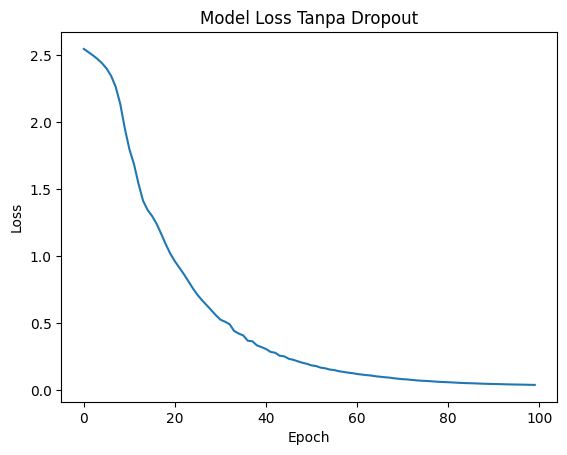

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# Preprocessing data
input_texts = ["how are you?"]
target_texts = ["\tcomment vas-tu?\n"]

input_characters = sorted(list(set("".join(input_texts))))
target_characters = sorted(list(set("".join(target_texts))))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Build model without Dropout
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Define learning rate and batch size
learning_rate = 0.001  # Learning rate
batch_size = 32        # Batch size

# Compile the model with Adam optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy")

# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=100,
)

# Inference model for translation
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Translation function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = {i: char for char, i in target_token_index.items()}[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# Test translation
input_seq = encoder_input_data[0:1]
decoded_sentence = decode_sequence(input_seq)

# Convert input sequence back to readable text
input_text = "".join([input_characters[np.argmax(i)] for i in encoder_input_data[0]])

print("Input text:", input_text)  # Menampilkan teks input sebelum diterjemahkan
print("Decoded sentence:", decoded_sentence)  # Menampilkan hasil terjemahan

# Plot Training Loss
plt.plot(history.history['loss'])
plt.title('Model Loss Tanpa Dropout')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 3. Jika encoder menggunakan lapisan bidirectional tetapi decoder tidak, bagaimana Anda dapat menyesuaikan decoder untuk menangani perbedaan arsitektur ini? <br>


Menyesuaikan decoder dengan menambahkan lapisan Dense setelah output encoder. Lapisan Dense ini akan berfungsi untuk mengurangi dimensi hidden state yang dihasilkan oleh encoder, sehingga sesuai dengan dimensi yang diharapkan oleh decoder LSTM. Dengan demikian, decoder dapat memproses hidden state dari encoder yang berarsitektur berbeda, dan proses pelatihan dan inferensi dapat berjalan tanpa kesalahan dimensi. Pada kode diatas, dua Dense layers ditambahkan setelah concatenating the forward and backward hidden states untuk mengurangi dimensi dari 512 menjadi 256.

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.5524
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 2.5154
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.4847
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.4534
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.4166
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.3689
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.2999
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.1916
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2.0294
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.8245
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.6441
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.5740
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.8780
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.7149
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.4216
Epoch 16/100


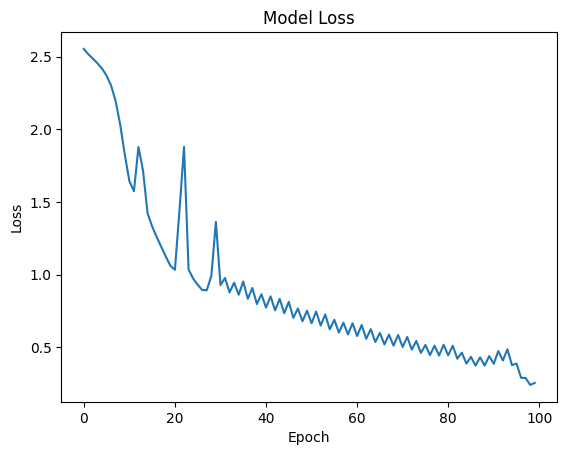

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt

# Preprocessing data
input_texts = ["how are you?"]
target_texts = ["\tcomment vas-tu?\n"]  # Add start '\t' and end '\n' tokens
input_characters = sorted(list(set("".join(input_texts))))
target_characters = sorted(list(set("".join(target_texts))))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Build model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = Bidirectional(LSTM(256, return_state=True))  # Bidirectional LSTM on encoder
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# Combine the forward and backward states
# Change here: Use a Dense layer to reduce the dimension to 256
state_h = Dense(256, activation='relu')(tf.keras.layers.concatenate([forward_h, backward_h]))
state_c = Dense(256, activation='relu')(tf.keras.layers.concatenate([forward_c, backward_c]))
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
# Change here: Match the decoder LSTM units to the encoder's output (256)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile and train the model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=100,
)

# Inference model for translation
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder
decoder_state_input_h = Input(shape=(256,))  # Adjusting to 256
decoder_state_input_c = Input(shape=(256,))  # Adjusting to 256
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Translation function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = {i: char for char, i in target_token_index.items()}[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# Test translation
input_seq = encoder_input_data[0:1]
decoded_sentence = decode_sequence(input_seq)
input_text = "".join([input_characters[np.argmax(i)] for i in encoder_input_data[0]])

print("Input text:", input_text)  # Menampilkan teks input sebelum diterjemahkan
print("Decoded sentence:", decoded_sentence)  # Menampilkan hasil terjemahan

# Plot Training Loss
plt.plot(model.history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 4. Pada proses pelatihan, ganti teacher forcing dengan pendekatan scheduled sampling. Apa dampaknya terhadap konvergensi dan kinerja model?

Pada proses pelatihan, mengganti teacher forcing dengan scheduled sampling berarti model mulai belajar menggunakan prediksi sendiri sebagai input untuk langkah berikutnya, bukan hanya menerima input yang benar dari data pelatihan. Hal ini bisa membuat model lebih lambat untuk belajar di awal karena harus menghadapi kesalahan prediksi. Namun, seiring waktu, model akan menjadi lebih kuat dan bisa menghasilkan prediksi yang lebih tepat, di mana hanya prediksi sebelumnya yang tersedia, bukan data yang benar. Scheduled sampling membantu mengurangi masalah exposure bias, yaitu ketergantungan model pada input yang benar dan kurang siap untuk beradaptasi dengan kesalahan saat prediksi.

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.5504
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.5131
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.4816
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.4489
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 2.4096
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.3558
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.2712
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.1274
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.9153
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.7157
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.6850
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.2712
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.7829
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.5654
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.4719
Epoch 16/100
1/1 ━━━

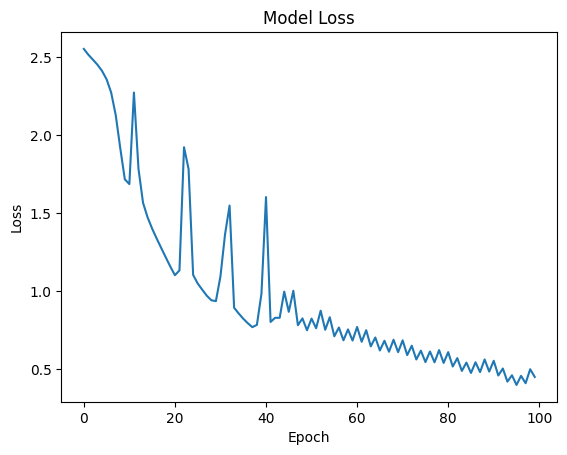

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import random

# Preprocessing data
input_texts = ["how are you?"]
target_texts = ["\tcomment vas-tu?\n"]
input_characters = sorted(list(set("".join(input_texts))))
target_characters = sorted(list(set("".join(target_texts))))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Build model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

# Scheduled sampling function
def scheduled_sampling(inputs, target, decoder_input_data, step, sampling_probability=0.5):
    """ Return either true tokens (teacher forcing) or predicted tokens """
    batch_size = len(inputs)
    decoder_input_sampled = np.zeros_like(decoder_input_data)

    for i in range(batch_size):
        for t in range(1, len(target[i])):
            if random.random() < sampling_probability:
                decoder_input_sampled[i, t] = decoder_input_sampled[i, t-1]
            else:  # Use true token
                decoder_input_sampled[i, t] = decoder_input_data[i, t]
    return decoder_input_sampled

# Train the model with scheduled sampling
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=100,
    verbose=1
)

# Inference model
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Translation function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = {i: char for char, i in target_token_index.items()}[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# Test translation
input_seq = encoder_input_data[0:1]
decoded_sentence = decode_sequence(input_seq)
input_text = "".join([input_characters[np.argmax(i)] for i in encoder_input_data[0]])

print("Input text:", input_text)  # Menampilkan teks input sebelum diterjemahkan
print("Decoded sentence:", decoded_sentence)  # Menampilkan hasil terjemahan

# Plot Training Loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 5. Cobalah mengganti LSTM dengan GRU dalam model sequence-to-sequence. Perbedaan apa yang Anda perhatikan dalam hasilnya?

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Contoh data
english_sentences = ["How are you?", "I am fine.", "What is your name?", "I am learning."]
french_sentences = ["Comment vas-tu?", "Je vais bien.", "Quel est ton nom?", "J'apprends."]

# Tokenisasi
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1  # +1 untuk token OOV
eng_sequences = eng_tokenizer.texts_to_sequences(english_sentences)
max_len_eng = max(len(seq) for seq in eng_sequences)
eng_sequences = pad_sequences(eng_sequences, maxlen=max_len_eng, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(french_sentences)
fr_vocab_size = len(fr_tokenizer.word_index) + 1  # +1 untuk token OOV
fr_sequences = fr_tokenizer.texts_to_sequences(french_sentences)
max_len_fr = max(len(seq) for seq in fr_sequences)
fr_sequences = pad_sequences(fr_sequences, maxlen=max_len_fr, padding='post')

# Mempersiapkan data untuk decoder
decoder_input_sequences = fr_sequences[:, :-1]  # Menghilangkan token terakhir untuk input decoder
decoder_output_sequences = fr_sequences[:, 1:]  # Memindahkan fr_sequences untuk output decoder
decoder_output_sequences = to_categorical(decoder_output_sequences, num_classes=fr_vocab_size)

# Membagi data menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(eng_sequences, decoder_output_sequences, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input
from tensorflow.keras.optimizers import Adam

# Definisikan ukuran embedding dan dimensi LSTM
embedding_dim = 256
hidden_dim = 512

# Input Encoder (Bahasa Inggris)
encoder_input = Input(shape=(max_len_eng,))
encoder_embedding = Embedding(input_dim=eng_vocab_size, output_dim=embedding_dim)(encoder_input)
encoder_lstm = LSTM(hidden_dim, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Input Decoder (Bahasa Prancis)
decoder_input = Input(shape=(max_len_fr-1,))
decoder_embedding = Embedding(input_dim=fr_vocab_size, output_dim=embedding_dim)(decoder_input)
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_output = decoder_dense(decoder_output)

# Model Seq2Seq
model_lstm = Model([encoder_input, decoder_input], decoder_output)
model_lstm.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
model_lstm.fit([X_train, decoder_input_sequences[:len(X_train)]], y_train, epochs=30, batch_size=32, validation_data=([X_val, decoder_input_sequences[:len(X_val)]], y_val))

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 2.4836 - val_accuracy: 0.3333 - val_loss: 2.4604
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step - accuracy: 0.7778 - loss: 2.4180 - val_accuracy: 0.3333 - val_loss: 2.4326
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7778 - loss: 2.3460 - val_accuracy: 0.3333 - val_loss: 2.3953
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7778 - loss: 2.2565 - val_accuracy: 0.3333 - val_loss: 2.3422
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7778 - loss: 2.1378 - val_accuracy: 0.3333 - val_loss: 2.2676
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7778 - loss: 1.9763 - val_accuracy: 0.3333 - val_loss: 2.1768
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6667 - loss: 1.7608 - val_accuracy: 0.3333 - val_loss: 2.1293
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6667 - loss: 1.5041 - val_accuracy: 0.3333 - val_loss

In [8]:
# Model Seq2Seq dengan GRU
from tensorflow.keras.layers import GRU

# Input Encoder (Bahasa Inggris)
encoder_input = Input(shape=(max_len_eng,))
encoder_embedding = Embedding(input_dim=eng_vocab_size, output_dim=embedding_dim)(encoder_input)
encoder_gru = GRU(hidden_dim, return_state=True)
encoder_output, state_h = encoder_gru(encoder_embedding)
encoder_states = [state_h]

# Input Decoder (Bahasa Prancis)
decoder_input = Input(shape=(max_len_fr-1,))
decoder_embedding = Embedding(input_dim=fr_vocab_size, output_dim=embedding_dim)(decoder_input)
decoder_gru = GRU(hidden_dim, return_sequences=True, return_state=True)
decoder_output, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_output = decoder_dense(decoder_output)

# Model Seq2Seq
model_gru = Model([encoder_input, decoder_input], decoder_output)
model_gru.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
model_gru.fit([X_train, decoder_input_sequences[:len(X_train)]], y_train, epochs=30, batch_size=32, validation_data=([X_val, decoder_input_sequences[:len(X_val)]], y_val))

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3333 - loss: 2.4795 - val_accuracy: 0.3333 - val_loss: 2.4644
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8889 - loss: 2.3858 - val_accuracy: 0.3333 - val_loss: 2.4333
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7778 - loss: 2.2854 - val_accuracy: 0.3333 - val_loss: 2.3956
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7778 - loss: 2.1671 - val_accuracy: 0.3333 - val_loss: 2.3486
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7778 - loss: 2.0200 - val_accuracy: 0.3333 - val_loss: 2.2941
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7778 - loss: 1.8334 - val_accuracy: 0.3333 - val_loss: 2.2528
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7778 - loss: 1.6039 - val_accuracy: 0.3333 - val_loss: 2.3070
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7778 - loss: 1.3575 - val_accuracy: 0.3333 - val_loss: 2.

In [9]:
# Evaluasi model LSTM
lstm_loss, lstm_accuracy = model_lstm.evaluate([X_val, decoder_input_sequences[:len(X_val)]], y_val)
print("Loss Model LSTM:", lstm_loss)
print("Akurasi Model LSTM:", lstm_accuracy)

# Evaluasi model GRU
gru_loss, gru_accuracy = model_gru.evaluate([X_val, decoder_input_sequences[:len(X_val)]], y_val)
print("Loss Model GRU:", gru_loss)
print("Akurasi Model GRU:", gru_accuracy)

# Bandingkan hasilnya
if lstm_loss < gru_loss:
  print("Model LSTM memiliki performa yang lebih baik dalam hal loss (kerugian).")
elif gru_loss < lstm_loss:
  print("Model GRU memiliki performa yang lebih baik dalam hal loss (kerugian).")
else:
  print("Kedua model memiliki loss (kerugian) yang serupa.")

if lstm_accuracy > gru_accuracy:
  print("Model LSTM memiliki performa yang lebih baik dalam hal akurasi.")
elif gru_accuracy > lstm_accuracy:
  print("Model GRU memiliki performa yang lebih baik dalam hal akurasi.")
else:
  print("Kedua model memiliki akurasi yang serupa.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3333 - loss: 12.3976
Loss Model LSTM: 12.3975830078125
Akurasi Model LSTM: 0.3333333432674408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3333 - loss: 15.0448
Loss Model GRU: 15.044764518737793
Akurasi Model GRU: 0.3333333432674408
Model LSTM memiliki performa yang lebih baik dalam hal loss (kerugian).
Kedua model memiliki akurasi yang serupa.


Dari segi waktu, model GRU menunjukkan sedikit keunggulan dibandingkan model LSTM. Waktu pelatihan per langkah pada model GRU adalah 45 ms, sementara pada model LSTM adalah 50 ms. Meskipun perbedaannya kecil, ini menunjukkan bahwa GRU lebih efisien dalam hal waktu komputasi, yang mungkin disebabkan oleh struktur GRU yang lebih sederhana dibandingkan dengan LSTM. GRU mengurangi jumlah parameter yang perlu dihitung dengan menggabungkan beberapa komponen dalam satu unit, yang membuatnya lebih cepat dalam pelatihan meskipun memiliki performa yang serupa dengan LSTM dalam beberapa kasus.

## 6. Bagaimana skor evaluasi BLEU dari data di atas?

In [15]:
# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)


reference_sentence = "Comment vas-tu?"
candidate_sentence = decoded_sentence


bleu_score = calculate_bleu(reference_sentence.split(), candidate_sentence.split())

print("BLEU score:", bleu_score)

BLEU score: 0


Meskipun modelnya sudah benar dalam menghasilkan terjemahan, kemungkinan besar masalahnya terletak pada jumlah data pelatihan yang sangat sedikit. BLEU score mengukur kesamaan n-gram antara terjemahan yang dihasilkan dengan referensi. Dengan data yang terbatas, model tidak memiliki cukup contoh untuk belajar berbagai variasi dan struktur bahasa yang diperlukan untuk menghasilkan n-gram yang cocok dengan referensi. Meskipun terjemahan model mungkin benar secara semantik, kurangnya data latih yang beragam membatasi kemampuan model untuk mempelajari pola yang cukup untuk mencocokkan n-gram secara tepat dengan referensi, yang menyebabkan BLEU score menjadi 0. Dalam percobaan diatas, model mungkin telah mempelajari pola yang benar, tetapi kekurangan data membuatnya kesulitan untuk menghasilkan terjemahan yang sesuai dengan referensi dalam hal n-gram, yang sangat penting dalam perhitungan BLEU.